## Классификация изображений

### План семинара:

0) Ответы на любые вопросы 🤷 ¯\\_(ツ)_/¯

1) Обучим сверточную сеть в задаче классификации изображений и посмотрим на полученные фильтры свёрток

1.5) Посмотрим, а есть ли у нас проблемы?

2) Добавим аугментацию

3) Усложняем архитектуру сети для улучшения качества

In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

~~device = 'cuda'~~

~~torch.cuda.is_available()~~

~*Кринж*. Так лучше не делать) 

In [2]:
device = 'cuda'


# MyNet(): .....  model = MyNet(100, 100) -> model.to('cuda') # <- error if only CPU available

In [3]:
# Не кринж:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
!nvidia-smi

Thu Sep 30 11:47:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Обучаем свёрточную сеть для задачи классификации изображений

Сегодня будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000.

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # средние и дисперсии по каналам

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


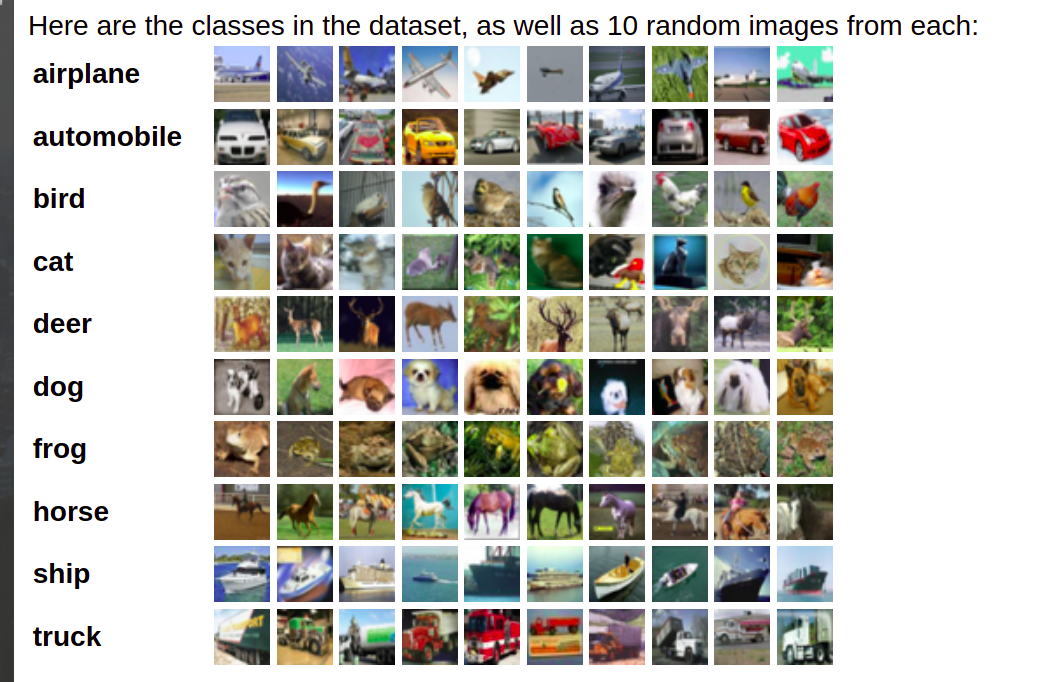

In [7]:
for batch in train_dataloader:
    sample, answer = batch
    print(sample.size(), answer.size())   # (bs, ch, h, w), (bs)
    break

torch.Size([16, 3, 32, 32]) torch.Size([16])


In [8]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

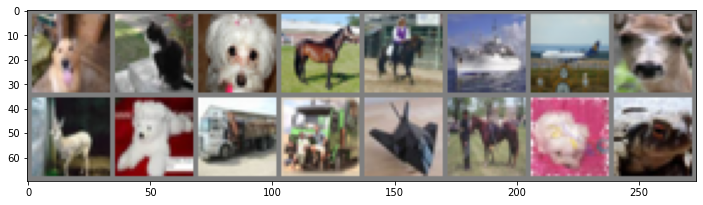

In [9]:
plt.figure(figsize=(12,12))

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

In [10]:
NUM_EPOCH = 25

In [11]:
import wandb
wandb.login()

wandb: Currently logged in as: kirili4ik (use `wandb login --relogin` to force relogin)


True

In [12]:
# We will use wandb to skip this frightening code:

import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

В качестве бейзлайна возьмем сверточную сеть, состоящую из 1 VGG блока.

VGG блок состоит из двух последовательных сверточных слоев с нелинейностью ReLU между ними, а затем max-pooling. В VGG используются маленькие фильтры размера 3x3 и паддинг

### В качестве бейзлайна постройте следующую архитектуру:

1) VGG блок с 16 каналами:
* свёрточный слой с 16 выходными каналами и ядром 3x3 и нелинейностью ReLU
* свёрточный слой с 16 выходными каналами и ядром 5x5 и нелинейностью ReLU
* Max pooling c ядром 2x2 и шагом 2

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами и Softmax

In [13]:
# Размер linear1 зависит от размера входной картинки:
# in_ch * out_ch ker * ker    # 32*32 или 28*28 или 256*256 

# GlobalAveragePool  # 32*32, 16ch -> 3*3, 100ch # 32*32 на вход, но и 128*128 -> 10*10, 100ch  # 
# 256*256, 250*250 или 270*270 

In [14]:
class ModelBaseline(nn.Module):
    def __init__(self, hidden=16):
        super(ModelBaseline, self).__init__()
        self.conv1   = nn.Conv2d(in_channels=3, out_channels=hidden,  kernel_size=(3,3), padding=3//2)
        self.conv2   = nn.Conv2d(in_channels=hidden, out_channels=hidden,  kernel_size=(5,5), padding=5//2)
        self.relu    = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)  # (2,2)
        self.linear1 = nn.Linear(32*32*hidden//4, 128)
        self.linear2 = nn.Linear(128, 10)
        self.flatten = nn.Flatten()

        # Example:
        # self.layer_name = Layer(params)
        # ...
        # create 1 ReLU and 1 MaxPool layers and use them 2+ times in forward


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        flattened = self.flatten(self.maxpool(x))
        x = self.relu(self.linear1(flattened))
        return self.linear2(x) 
        # no softmax to use CrossEntropyLoss later

In [15]:
model_baseline = ModelBaseline(hidden=16)

model_baseline.to(device)

ModelBaseline(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4096, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [18]:
wandb.init(project="conv-sem03", name='baseline')
wandb.watch(model_baseline)

[]

## Задание: допишите цикл обучения

## 1.5. Перед запуском: что мы забыли?

In [20]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #random.seed(seed)
    #np.random.seed(seed)

set_seed(42)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


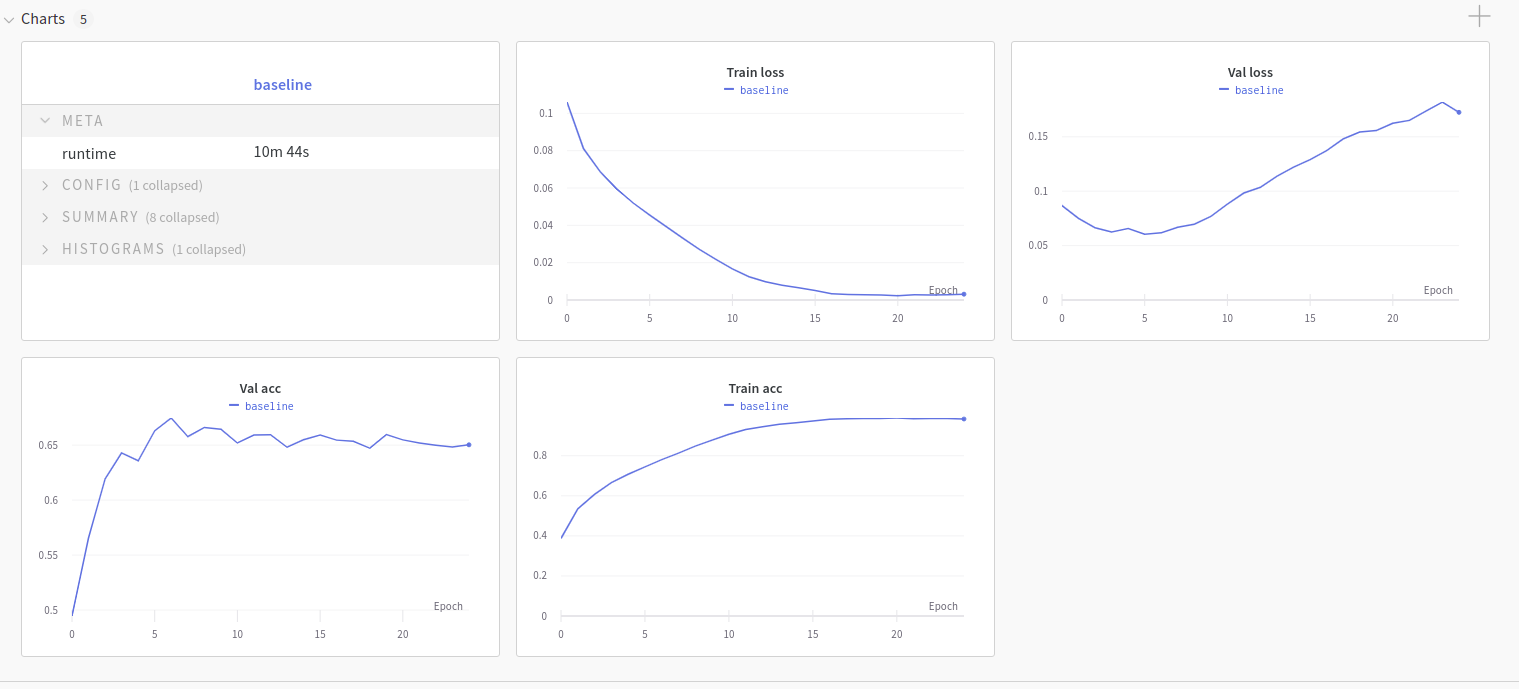

## Визуализируем параметры сети

Для запуска из колаба загрузите в свой google drive файл filter_viz.py и запустите ячейки ниже. При запуске с локальной машины следующие две ячейки можно пропустить.

In [26]:
!wget https://raw.githubusercontent.com/Kirili4ik/iad-deep-learning/premium/2021/sem03/filter_viz.py

--2021-09-30 12:01:53--  https://raw.githubusercontent.com/Kirili4ik/iad-deep-learning/premium/2021/sem03/filter_viz.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3293 (3.2K) [text/plain]
Saving to: ‘filter_viz.py’

filter_viz.py       100%[===================>]   3.22K  --.-KB/s    in 0s      

2021-09-30 12:01:53 (56.5 MB/s) - ‘filter_viz.py’ saved [3293/3293]



In [27]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [28]:
#import sys
#sys.path.append('/content/gdrive/My Drive')

In [29]:
from filter_viz import plot_filters

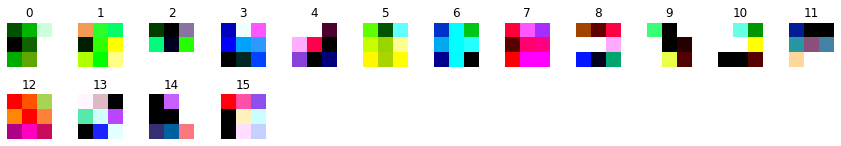

In [30]:
model_baseline.cpu()

plot_filters(model_baseline.conv1, single_channel=False)

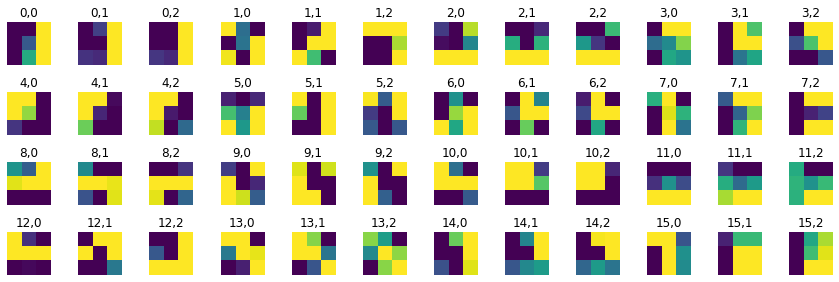

In [31]:
plot_filters(model_baseline.conv1, single_channel=True)

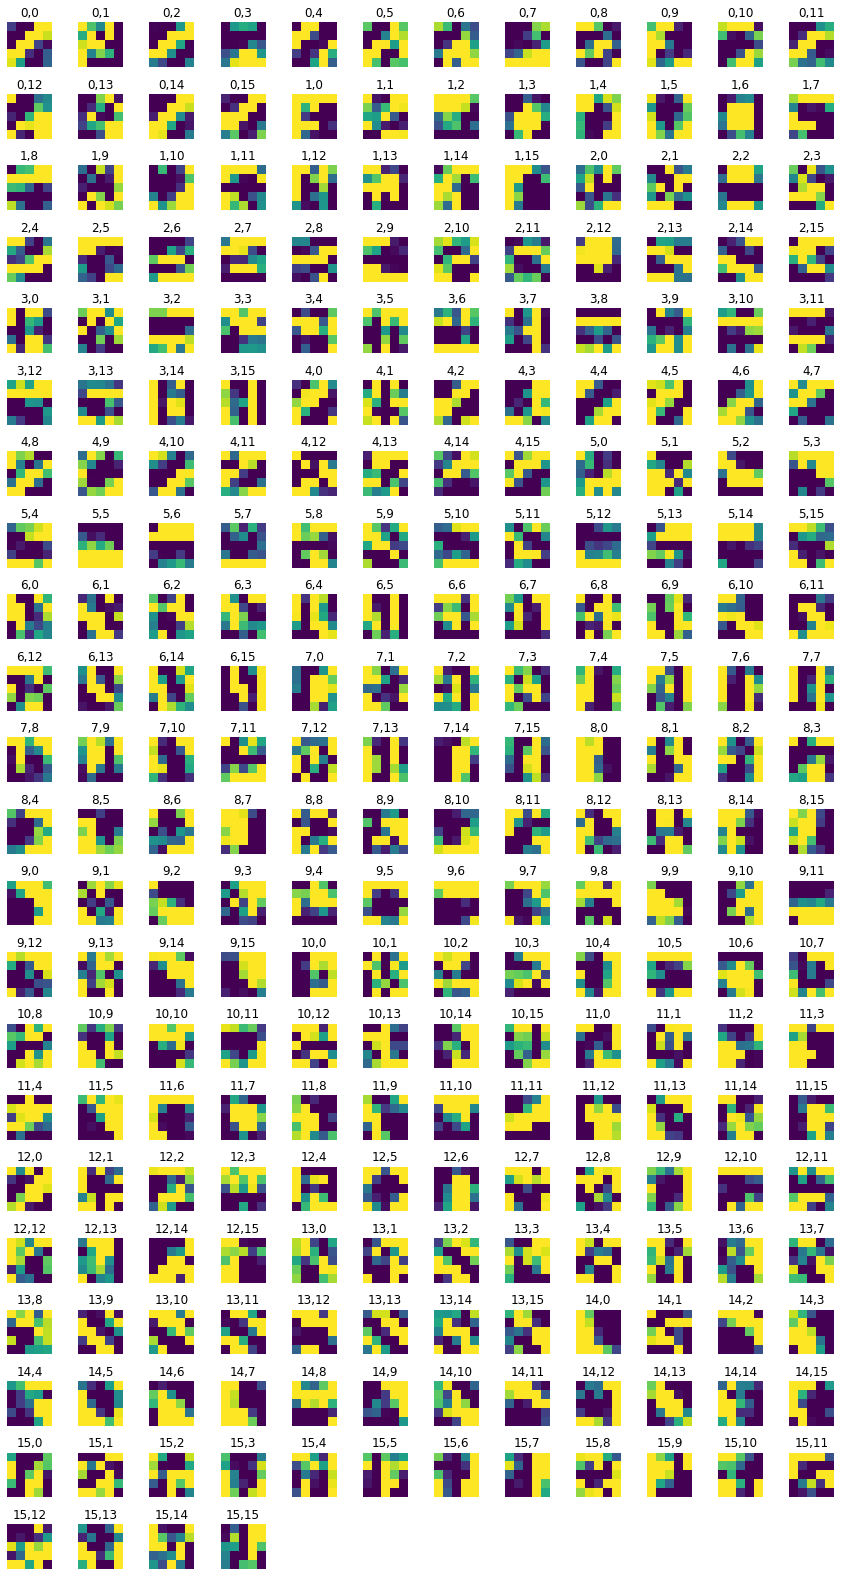

In [32]:
plot_filters(model_baseline.conv2, single_channel=True)

## Задание:

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

[Почитать про разные функции активации можно здесь](https://mlfromscratch.com/activation-functions-explained/#/)

In [33]:
# self.relu    = nn.LeakyReLU()

# 2. Аугментация

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/vision/stable/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения

In [34]:
import PIL

transform = transforms.Compose(
    [transforms.ColorJitter(hue=.05, saturation=.05),    # подмешивание цветов (яркость, насыщенность и тд)
     transforms.RandomHorizontalFlip(p=0.5),             # поворот картинки относительно вертикальной оси с вероятность 50% 
     transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),     # поворот картинки на случайное значение от -20 до 20 градусов
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Files already downloaded and verified
Files already downloaded and verified


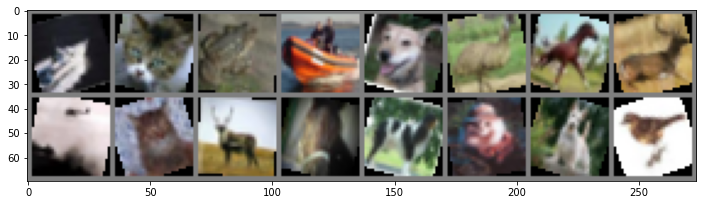

In [35]:
plt.figure(figsize=(12,12))

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

In [36]:
model_base = ModelBaseline()
model_base.to(device)
wandb.init(project="conv-sem03", name='add augmentations')
wandb.watch(model_baseline)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

train(model_base, criterion, optimizer, train_dataloader, test_dataloader)

Train acc,0.9834
Train loss,0.00312
Val acc,0.6503
Val loss,0.17248


Train acc,▁▃▄▄▅▅▆▆▆▇▇▇▇████████████
Train loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▁▄▆▇▆██▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Val loss,▃▂▁▁▁▁▁▁▂▂▃▃▃▄▅▅▅▆▆▆▇▇██▇


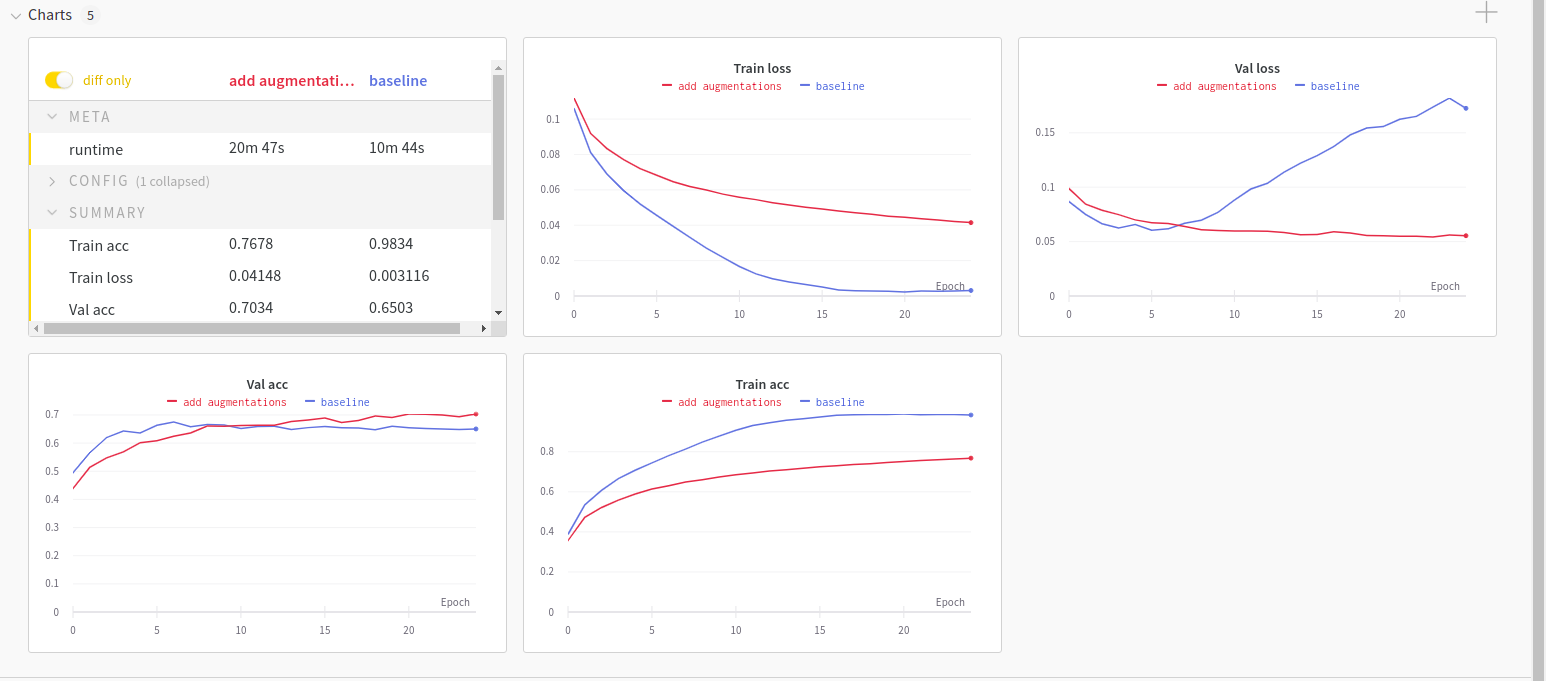

```
Обратите внимание:

1) Время обучения увеличилось в 2 раза

2) Accuracy на аугментации выросла на 5% (65/70).

```

# 3. Как улучшить качество модели?

Особенность VGG блока заключается в том, что повышение качества работы сети достигается увеличением числа последовательных блоков. При этом число фильтров в каждом новом блоке в два раза больше, чем в предыдущем. Давайте попробуем объединить 3 VGG блока.

## **Dropout**

Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим будем использовать Dropout

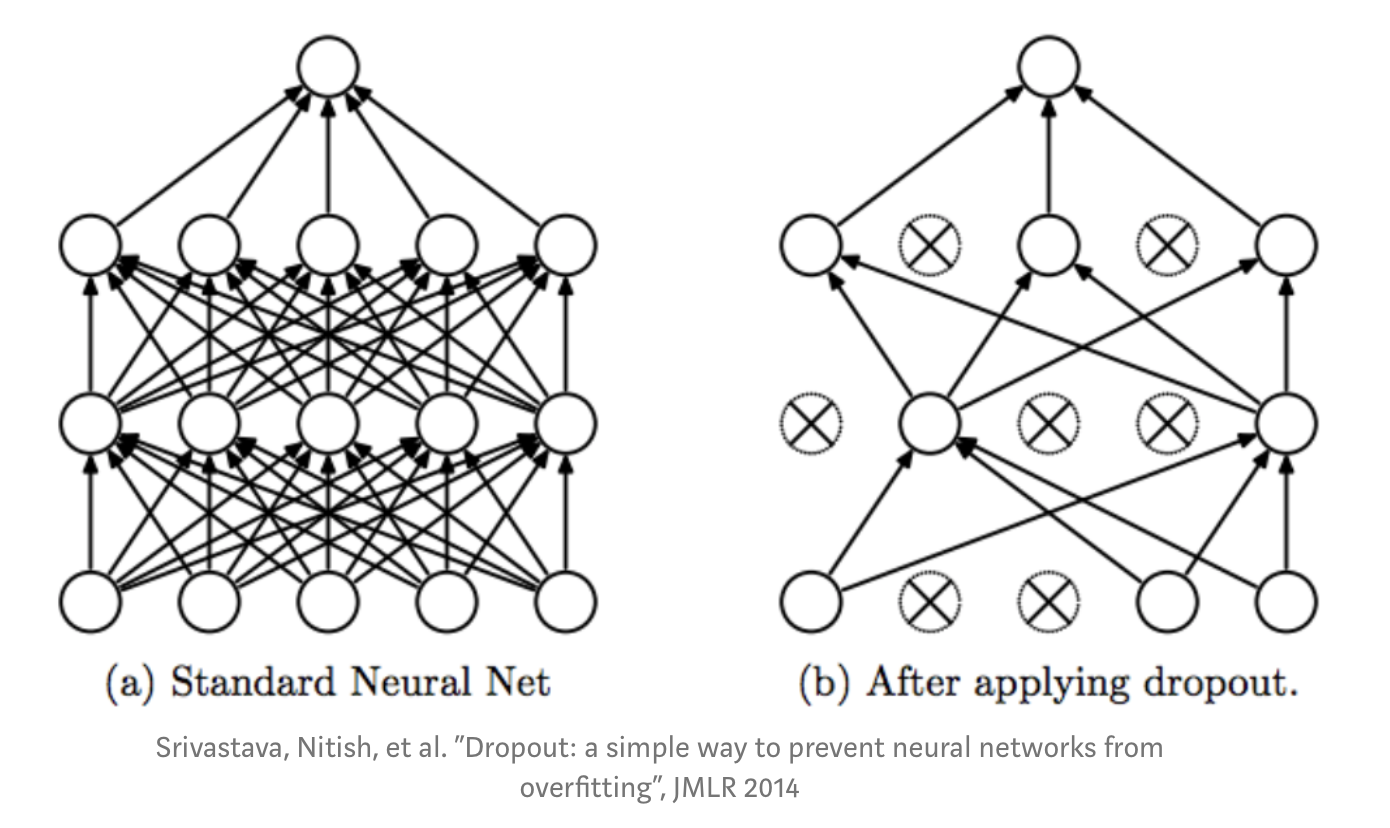

Добавим Dropout с параметром 0.2 после каждого VGG блока и после 1 полносвязного слоя и его нелинейности.

для ускорения и стабилизации обучения добавим [BatchNorm](https://habr.com/ru/post/309302///) после каждого сверточного слоя и после 1 полносвязного слоя
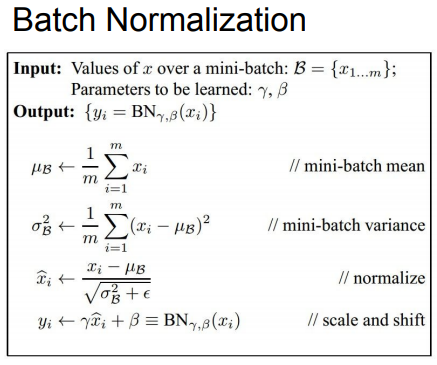


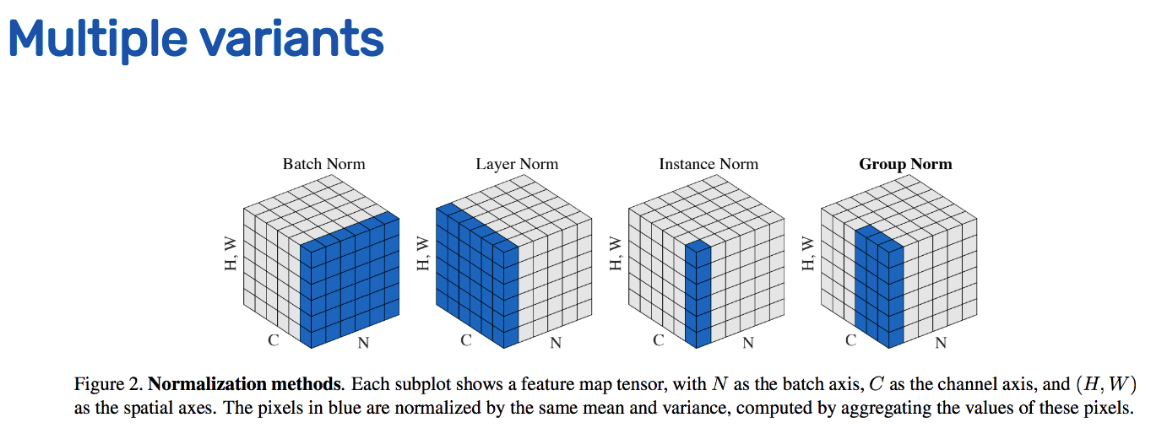

```
По картинке видно, что для использования BatchNorm нам надо знать количество каналов C. На самом деле BatchNorm (очень упрощая) усредняет по батчу, а таких (~)усреднений надо сделать C штук.

```

### Практические рекоммендации:

**1)** При работе с картинками всегда используйте BatchNorm

**2)** При использовании BatchNorm берите побольше батчсайз; Вначале обучение может быть медленным; Не забывайте model.train() и model.eval() т.к. BN и Dropout работают по разному во время обучения и инференса(теста).

In [37]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),              # 16 is the number of channels
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax()
)

In [38]:
model.to(device)

wandb.init(project="conv-sem03", name='+augs +BatchNorm + Dropout')
wandb.watch(model)

Train acc,0.76784
Train loss,0.04148
Val acc,0.7034
Val loss,0.05539


Train acc,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████
Train loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Val acc,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇█▇▇███████
Val loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁


[]

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


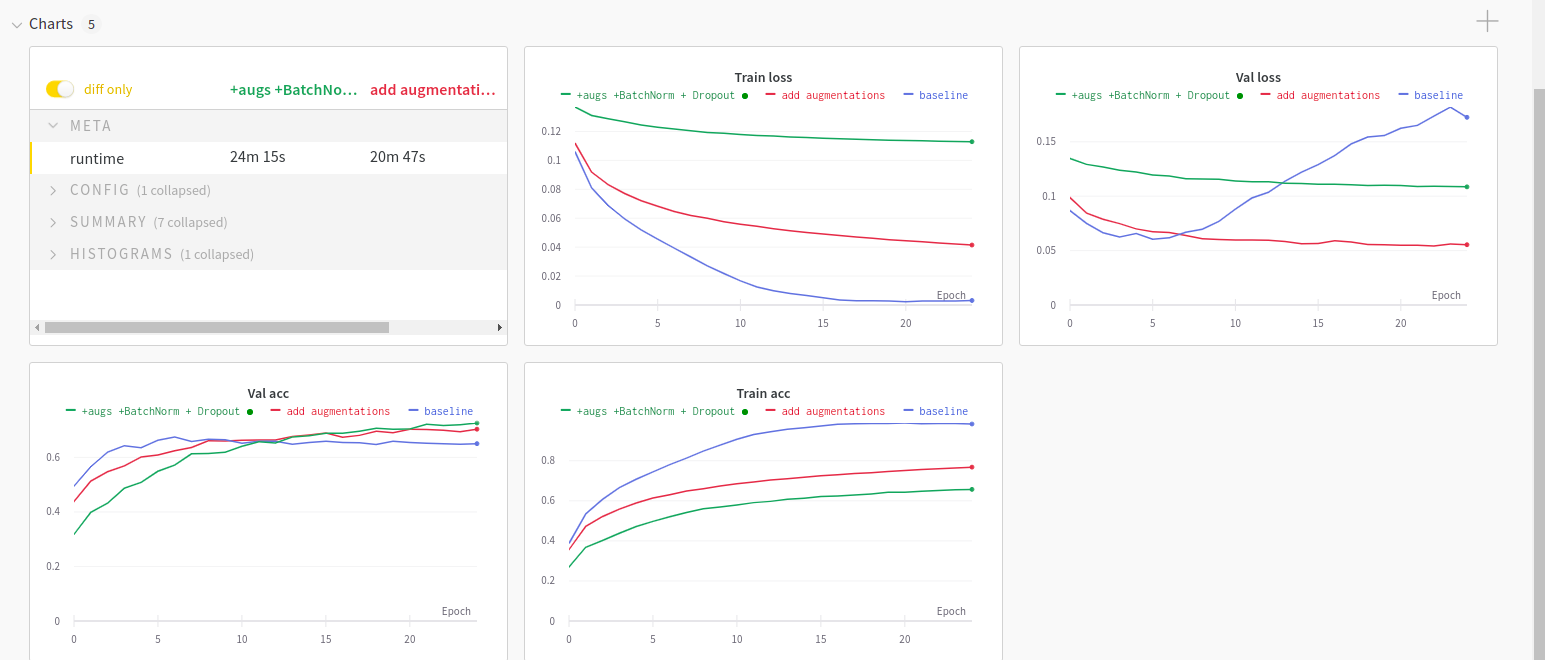

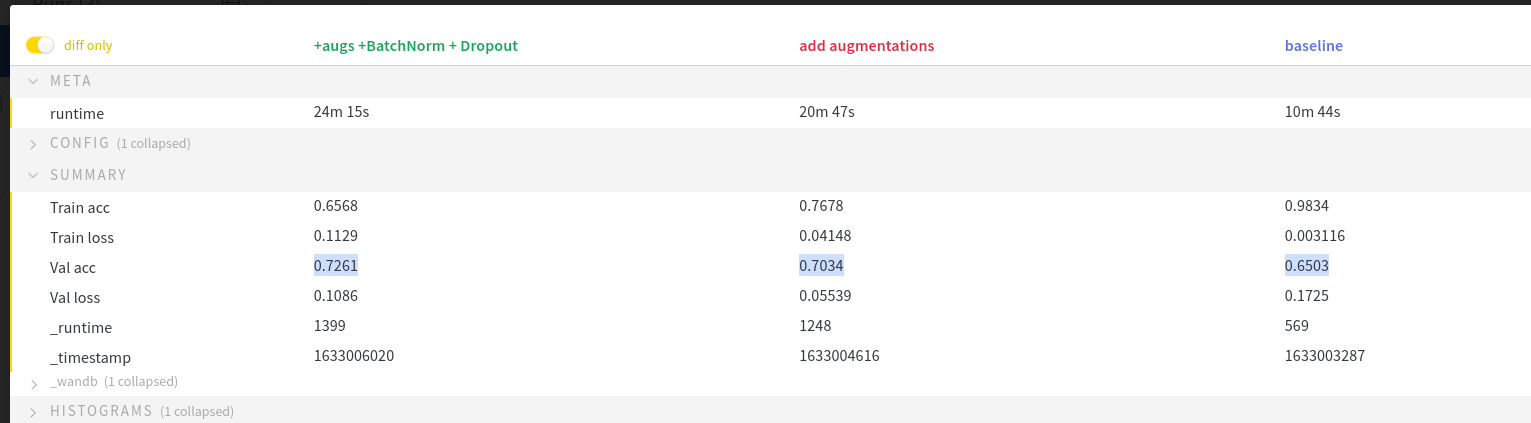

```

Обратите внимание, что:

1) Мы увеличили accuracy на ~10%

2) Каждый в отдельности график выглядит по разному - поэтому важно логировать как можно больше всего!

```